In [ ]:
# Assignment: Longest Common Subsequence (HPC Project)
# Student: Parrella Marco, Matricola: 0622702536, Email: m.parrella21@studenti.unisa.it
# Lecturer: Moscato Francesco, fmoscato@unisa.it
#
# License: GPLv3 (see LICENSE file)
# Requirements: Implement Parallel LCS (OpenMP, MPI, CUDA)
# Purpose: Script per l'analisi dei risultati (CSV) e la generazione dei grafici di performance (Time, Speedup, Block Size).

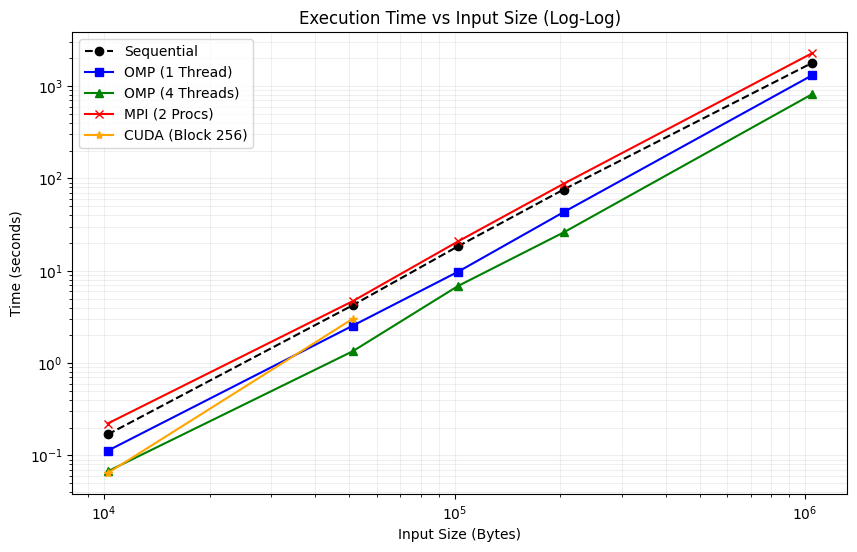

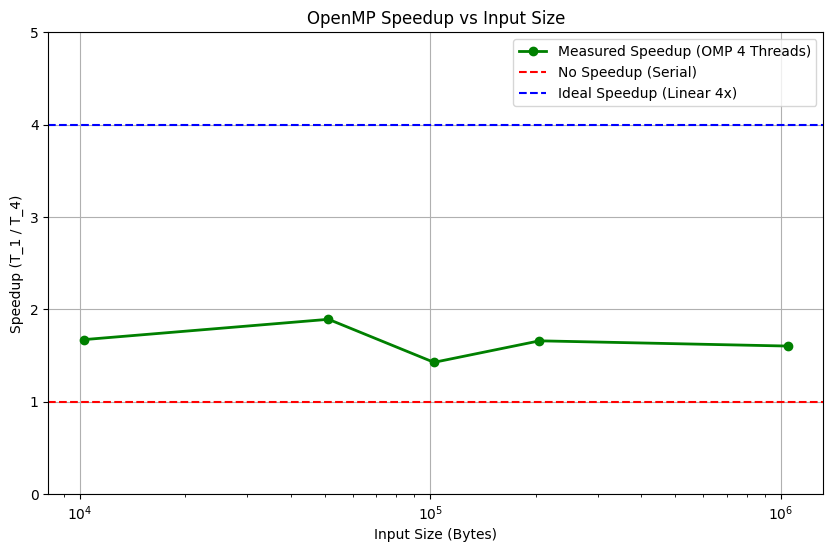

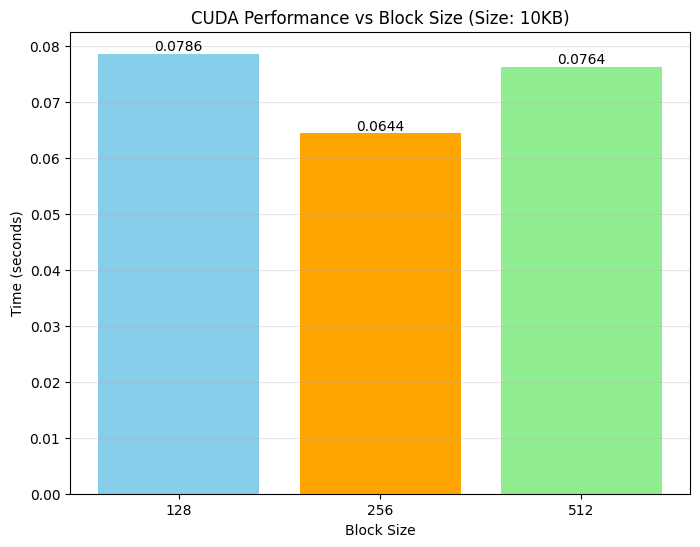

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np

# 1. I DATI
csv_data = """
impl,size,rep,param,time_s
seq,10240,1,NA,0.191873
omp,10240,1,1,0.119722
omp,10240,1,4,0.064116
mpi,10240,1,2,0.221953
seq,10240,2,NA,0.161714
omp,10240,2,1,0.094926
omp,10240,2,4,0.066067
mpi,10240,2,2,0.262435
seq,10240,3,NA,0.152864
omp,10240,3,1,0.122899
omp,10240,3,4,0.071736
mpi,10240,3,2,0.181256
seq,51200,1,NA,4.249152
omp,51200,1,1,2.633425
omp,51200,1,4,1.266897
mpi,51200,1,2,4.461154
seq,51200,2,NA,4.107143
omp,51200,2,1,2.438359
omp,51200,2,4,1.356851
mpi,51200,2,2,4.757315
seq,51200,3,NA,4.339075
omp,51200,3,1,2.553966
omp,51200,3,4,1.406823
mpi,51200,3,2,4.846455
seq,102400,1,NA,16.267525
omp,102400,1,1,10.049556
omp,102400,1,4,10.358943
mpi,102400,1,2,19.559531
seq,102400,2,NA,22.633075
omp,102400,2,1,9.494483
omp,102400,2,4,5.226122
mpi,102400,2,2,18.321910
seq,102400,3,NA,16.493845
omp,102400,3,1,9.813251
omp,102400,3,4,4.999887
mpi,102400,3,2,24.658801
seq,204800,1,NA,73.028451
omp,204800,1,1,40.058169
omp,204800,1,4,26.297356
mpi,204800,1,2,90.705879
seq,204800,2,NA,75.527716
omp,204800,2,1,46.908398
omp,204800,2,4,28.214438
mpi,204800,2,2,88.319754
seq,204800,3,NA,79.368978
omp,204800,3,1,42.719974
omp,204800,3,4,23.658327
mpi,204800,3,2,84.061000
seq,1048576,1,NA,1788.565605
omp,1048576,1,1,1313.592361
omp,1048576,1,4,819.798576
mpi,1048576,1,2,2279.155453
cuda,10240,1,128,0.109924
cuda,10240,1,256,0.064252
cuda,10240,1,512,0.076628
cuda,10240,2,128,0.060675
cuda,10240,2,256,0.064462
cuda,10240,2,512,0.076243
cuda,10240,3,128,0.065312
cuda,10240,3,256,0.064488
cuda,10240,3,512,0.076185
cuda,51200,1,128,2.992495
cuda,51200,1,256,3.016323
cuda,51200,1,512,3.072156
cuda,51200,2,128,2.995034
cuda,51200,2,256,3.016395
cuda,51200,2,512,3.078468
cuda,51200,3,128,3.002448
cuda,51200,3,256,3.023699
cuda,51200,3,512,3.081815
"""

# --- FIX: dtype={'param': str} forza la lettura come stringa ---
df = pd.read_csv(io.StringIO(csv_data), skipinitialspace=True, dtype={'param': str})
df = df.dropna(how='all')

# Pulizia ulteriore per sicurezza (toglie spazi e converte NaN in 'NA' se serve)
df['param'] = df['param'].astype(str).str.strip()
df['impl'] = df['impl'].astype(str).str.strip()

# Calcolo media sui rep
df_mean = df.groupby(['impl', 'size', 'param'])['time_s'].mean().reset_index()

# ---------------------------------------------------------
# GRAFICO 1: Tempo di esecuzione vs Dimensione (Log-Log)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

seq_data = df_mean[df_mean['impl'] == 'seq']
omp1_data = df_mean[(df_mean['impl'] == 'omp') & (df_mean['param'] == '1')]
omp4_data = df_mean[(df_mean['impl'] == 'omp') & (df_mean['param'] == '4')]
mpi_data = df_mean[df_mean['impl'] == 'mpi']
cuda_data = df_mean[(df_mean['impl'] == 'cuda') & (df_mean['param'] == '256')]

plt.plot(seq_data['size'], seq_data['time_s'], marker='o', label='Sequential', linestyle='--', color='black')
plt.plot(omp1_data['size'], omp1_data['time_s'], marker='s', label='OMP (1 Thread)', color='blue')
plt.plot(omp4_data['size'], omp4_data['time_s'], marker='^', label='OMP (4 Threads)', color='green')
plt.plot(mpi_data['size'], mpi_data['time_s'], marker='x', label='MPI (2 Procs)', color='red')
if not cuda_data.empty:
    plt.plot(cuda_data['size'], cuda_data['time_s'], marker='*', label='CUDA (Block 256)', color='orange')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Input Size (Bytes)')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs Input Size (Log-Log)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.savefig('grafico1_time_vs_size.png')
plt.show()

# ---------------------------------------------------------
# GRAFICO 2: Speedup OpenMP (1 vs 4 threads) con Amdahl/Ideale
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

omp_merged = pd.merge(
    omp1_data[['size', 'time_s']],
    omp4_data[['size', 'time_s']],
    on='size',
    suffixes=('_1', '_4')
)
omp_merged['speedup'] = omp_merged['time_s_1'] / omp_merged['time_s_4']

# Linea dei dati misurati
plt.plot(omp_merged['size'], omp_merged['speedup'], marker='o', color='green', linewidth=2, label='Measured Speedup (OMP 4 Threads)')

# Linee di riferimento
plt.axhline(y=1, color='red', linestyle='--', label='No Speedup (Serial)')
plt.axhline(y=4, color='blue', linestyle='--', label='Ideal Speedup (Linear 4x)')

plt.xscale('log')
plt.ylim(0, 5)
plt.xlabel('Input Size (Bytes)')
plt.ylabel('Speedup (T_1 / T_4)')
plt.title('OpenMP Speedup vs Input Size')
plt.legend()
plt.grid(True)
plt.savefig('grafico2_omp_speedup.png')
plt.show()

# ---------------------------------------------------------
# GRAFICO 3: CUDA Performance vs Block Size
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))

cuda_10k = df_mean[(df_mean['impl'] == 'cuda') & (df_mean['size'] == 10240)].sort_values(by='param')

if not cuda_10k.empty:
    bars = plt.bar(cuda_10k['param'], cuda_10k['time_s'], color=['skyblue', 'orange', 'lightgreen'])
    plt.xlabel('Block Size')
    plt.ylabel('Time (seconds)')
    plt.title('CUDA Performance vs Block Size (Size: 10KB)')
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig('grafico3_cuda_blocks.png')
    plt.show()
else:
    print("Nessun dato CUDA trovato per il grafico 3.")